# Aerodynamic Splatting

In [20]:
import numpy as np
from sympy import symbols, diff, Quaternion, exp, Matrix, lambdify, sin, cos, simplify, latex
#from sympy.physics.mechanics import *
import random
from IPython.display import display
import matplotlib.pyplot as plt
from aerosplat import *
AeroSplatSolution

aerosplat.solution.AeroSplatSolution

## Symbolic Math

## Equation for quaternion
We provide two options for obtaining the quaternon.
In the case where a `numpy` array with four quaternion components are provided, we will obtain using the standard syntax `Quaternion(qw, qx, qy, qz)`.
In the case where a single component is provided, we will assume that this is a planar model with an angle evaluated about the $z$-axis, and obtain with the `Quaternion.from_axis_angle` class method.
We also will create the `idx_dimension` variable which shrinks subsequent matrices and vectors to use only the first two ($x$ and $y$) components.

In [21]:
display(quaternion_2d)

cos(θ/2) + 0*i + 0*j + sin(θ/2)*k

In [22]:
display(quaternion_3d)

q_w + q_x*i + q_y*j + q_z*k

## Equation for gaussian

The Gaussian equation that is created below uses the variance term _not-squared_, while in the plot I square this term.
There is reason for this; the variance that I will use below is going to be of the form

$\texttt{variance} = \sum_{i=1}^3 \left( \frac{x_i - \bar{x}_i}{s_i} \right)^2$

where $x_i$ is a position coordinate for where we are measuring, $\bar{x}_i$ is the position coordinate for the center of the Gaussian, and $s_i$ is a scale coefficient representing one standard deviation in the direction of that coordinate.
Traditionally, we would evaluate the Gaussian at some count of standard deviations, which would derive from the square-root of the above expression.
To avoid taking a square-root, just to subsequently square the term again, we create the Gaussian as a function of the variance directly.
However, the plot below shows an evaluation of the Gaussian with respect to standard deviations.

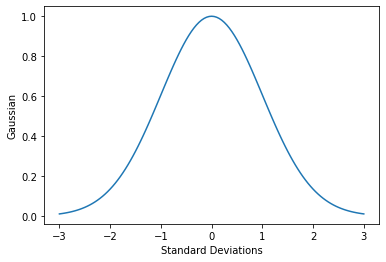

In [23]:
stdev = np.linspace(-3, 3, 121);
plt.plot(stdev, np.exp(-0.5 * stdev**2));
plt.xlabel("Standard Deviations");
plt.ylabel("Gaussian");

Here we create a function that obtains the rotation matrix from the quaternion, along with some simplification steps.
First, we substitute a value of 1 for the quaternion norm, as we will ensure that it is always a proper unit quaternion.
Second, we call the standard `simplify()` function.

In [24]:
display(rotation_eqn_2d)

Matrix([
[cos(θ), -sin(θ)],
[sin(θ),  cos(θ)]])

In [25]:
display(rotation_eqn_3d)
print(latex(rotation_eqn_2d))

Matrix([
[-2*q_y**2 - 2*q_z**2 + 1,   -2*q_w*q_z + 2*q_x*q_y,    2*q_w*q_y + 2*q_x*q_z],
[   2*q_w*q_z + 2*q_x*q_y, -2*q_x**2 - 2*q_z**2 + 1,   -2*q_w*q_x + 2*q_y*q_z],
[  -2*q_w*q_y + 2*q_x*q_z,    2*q_w*q_x + 2*q_y*q_z, -2*q_x**2 - 2*q_y**2 + 1]])

\left[\begin{matrix}\cos{\left(θ \right)} & - \sin{\left(θ \right)}\\\sin{\left(θ \right)} & \cos{\left(θ \right)}\end{matrix}\right]


In [26]:
display(Matrix(velocity_eqn_2d))

Matrix([
[u*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)],
[v*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)]])

We see the variance contained in the exponent

In [27]:
display(variance_eqn_2d)

s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 + s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2

### Velocity gradient equations

In [28]:
display(Matrix(variance_gradient_eqn_2d))

Matrix([
[ 2*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) + 2*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ)],
[-2*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) + 2*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ)]])

In [29]:
display(Matrix(velocity_gradient_eqn_2d))

Matrix([
[u*(-1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)],
[ v*(1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)]])

In [30]:
display(Matrix(velocity_gradient_matrix_eqn_2d))

Matrix([
[u*(-1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2), v*(-1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)],
[ u*(1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2),  v*(1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)]])

## Splatting Class

In [31]:
a = AeroSplat(
    position=[0, 0], 
    velocity=[1, 0],
    scale=[1, 1],
    orientation=[0]
)
display(a)
display(a.quaternion)
display(a.rotation_matrix)
rk = np.array([2, 0])
display(a.velocity_at(rk))
display(a.differential_velocity_at(rk))
display(a.velocity_gradient_at(rk))
display(a.velocity_gradient_matrix_at(rk))

AeroSplat(position=[0 0], velocity=[1 0], scale=[1 1], orientation=[0])

1 + 0*i + 0*j + 0*k

array([[ 1., -0.],
       [ 0.,  1.]])

array([0.13533528, 0.        ])

array([[ 0.27067057,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.13533528,  0.        ],
       [ 0.        ,  0.13533528],
       [-0.54134113, -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ]])

array([-0.27067057, -0.        ])

array([[-0.27067057, -0.        ],
       [ 0.        ,  0.        ]])

## Boundary Condition Class

In [32]:
source_boundary = LineBoundary(point0=[0, -1], point1=[0, 1], velocity=[10, 0])
plate_boundary = LineBoundary(point0=[1, -0.1], point1=[1, 0.1], velocity=[0, 0])
print(source_boundary)
print(source_boundary.point_at_random())

LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0])
[ 0.        -0.4827144]


## Problem Definition Class

In [33]:
problem = AeroSplatProblem(
    domain_x=[0, 2], 
    domain_y=[-1, 1],
    boundaries=[source_boundary, plate_boundary],
)
print(problem)

AeroSplatProblem(
  domain_x=[0 2]
  domain_y=[-1  1]
  boundaries=[LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0]), LineBoundary(point0=[ 1.  -0.1], point1=[1.  0.1], velocity=[0 0])]
)


## Solution Class

In [34]:
solution = AeroSplatSolution(problem, spawn=16) # TODO: handle errors if no spawn provided
print(solution.velocity_on_grid(2, 2))
print(solution.euler_equation_terms_at(np.array([0, 0])))
print(solution.ndims)
print(solution.splats)

[[[ 0.09969091  0.53309795]
  [ 1.14940584 -0.47771533]]

 [[ 0.01160033 -0.15277016]
  [ 0.03525029  0.01329469]]]
[[-0.57112128 -1.75550274]
 [-1.01941621  0.11435024]] 2
[-0.12510375 -0.22619707 -0.45677104]
2
[AeroSplat(position=[1.50058541 0.47409232], velocity=[-0.14169829  1.19126197], scale=[7.07250823 9.09027698], orientation=[-2.17530331]), AeroSplat(position=[0.96078015 0.73066877], velocity=[ 0.3980012  -0.04318938], scale=[6.2949363  6.29538304], orientation=[-2.89667782]), AeroSplat(position=[ 1.92975058 -0.90073791], velocity=[ 1.34914208 -0.37041667], scale=[2.56355064 8.76220255], orientation=[-2.27752134]), AeroSplat(position=[1.29600474 0.95798176], velocity=[0.42204239 0.16278424], scale=[2.89262498 5.0129967 ], orientation=[-0.33791352]), AeroSplat(position=[ 0.22940253 -0.27327753], velocity=[0.04075348 0.04932901], scale=[9.87261925 6.41204273], orientation=[1.99692994]), AeroSplat(position=[ 0.25120672 -0.58065661], velocity=[-2.4939337  -0.03361436], scale=[8.9

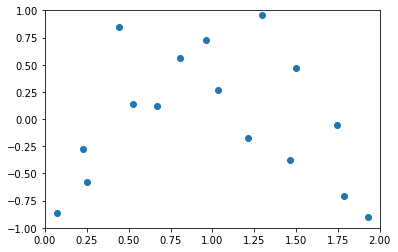

In [35]:
splat_positions = np.array([[splat.position[0], splat.position[1]] for splat in solution.splats])
plt.plot(splat_positions[:, 0], splat_positions[:, 1], "o");
plt.xlim(problem.domain_x);
plt.ylim(problem.domain_y);

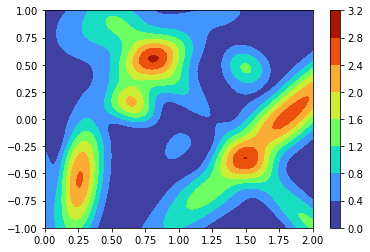

In [36]:
nx = 101
ny = 51
grid = problem.point_grid(nx, ny)
velocity_field = solution.velocity_on_grid(nx, ny)
contour_x = np.array([grid[0, k, 0] for k in range(nx)])
contour_y = np.array([grid[j, 0, 1] for j in range(ny)])
contour_z = np.array([[np.linalg.norm(velocity_field[j, k, :]) for k in range(nx)] for j in range(ny)])
plt.contourf(contour_x, contour_y, contour_z, cmap="turbo");
plt.colorbar();

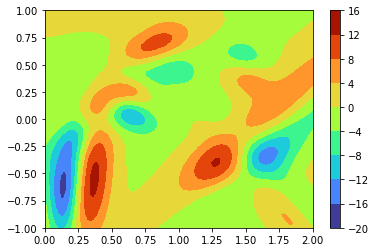

In [37]:
gradient_field = solution.velocity_gradient_on_grid(nx, ny)
#contour_z = np.array([[np.linalg.norm(gradient_field[j, k, :]) for k in range(nx)] for j in range(ny)])
contour_z = np.array([[sum(gradient_field[j, k, :]) for k in range(nx)] for j in range(ny)])
plt.contourf(contour_x, contour_y, contour_z, cmap="turbo");
plt.colorbar();

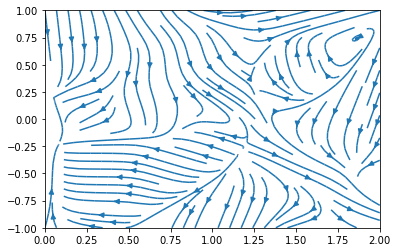

In [38]:
#print(solution.velocity_gradient_matrix_on_grid(nx, ny))
plt.streamplot(contour_x, contour_y, velocity_field[:, :, 0], velocity_field[:, :, 1])